# Implement K-Fold Cross Validation

### import functions

In [9]:
# import
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, f1_score, accuracy_score


### Data Loading

In [10]:
labels = pd.read_csv("Results/Machine_Learning/sample_map_ML.csv")
features  = pd.read_csv("Results/Machine_Learning/fragment_features_CNA_ML.csv")
# convert to long
features = pd.pivot(data = features, index = "sample", columns = "length", values = "count")
# convert into binary column
cancer_list = ["A", "B", "C", "Lung", "Breast"]

def binary(df):
    df["cancer"] = np.where(df["diagnosis"].isin(cancer_list), 1, 0)
    
    
    return df

# apply function and reshape df
labels = binary(labels)
labels.drop(columns = ["diagnosis"], inplace = True)
labels.set_index("sample", inplace = True)

# convert into numpy vectors
features = features.to_numpy(copy=True) 
labels = labels.to_numpy(copy=True)

### Train test split & kFold

In [11]:

def CV_analysis(split_, n_params, t_knn, t_logReg, t_ranFor):
    F1_matrix_knn = {"n_neighbors": []}
    F1_matrix_logReg = {"C_value": []}
    F1_matrix_ranFor = {"n_estimators": []}


    for index, (i_train, i_valid) in enumerate(split_):
        # splitting into train and validation set
        X_train, X_valid = X[i_train], X[i_valid]
        y_train, y_valid = y[i_train], y[i_valid]
        
        transformer = StandardScaler().fit(X_train) # compute mean, std on train
        X_valid = transformer.transform(X_valid)  # use same transformer for both, mimics that we do not know train data
        X_train = transformer.transform(X_train)

        # loop through each classifier, fit and predict the validation set

        for n_neighbors in np.linspace(t_knn[0], t_knn[1], n_params, dtype = "int"):

            # construct new Fi columns if i doesnt exist     
            if "F" + str(index+1) not in F1_matrix_knn.keys():
                F1_matrix_knn["F" + str(index+1)] = []

            # fit and predict with classifier
            knn = KNeighborsClassifier(n_neighbors=n_neighbors)
            knn.fit(X_train, y_train)
            y_predict = knn.predict(X_valid)

            # insert F1 value in matrix
            F1_matrix_knn["F" + str(index+1)].append(f1_score(y_valid, y_predict, average = "macro"))

            # for index labeling with paramters
            if n_neighbors not in F1_matrix_knn["n_neighbors"]:
                F1_matrix_knn["n_neighbors"].append(n_neighbors)
                
           # print("KNN: {} accuracy train: {} vs. valid {}".format(n_neighbors,
           #                                                      accuracy_score(y_train, knn.predict(X_train)),
           #                                                      accuracy_score(y_valid, knn.predict(X_valid))))
            
            

        # same as above        
        for C_value in np.linspace(t_logReg[0], t_logReg[1], n_params):


            if "F" + str(index+1) not in F1_matrix_logReg.keys():

                F1_matrix_logReg["F" + str(index+1)] = []

            logReg = LogisticRegression(penalty = "l1", solver = "liblinear", max_iter = 1000, C = C_value)
            logReg.fit(X_train, y_train)
            y_predict = logReg.predict(X_valid)

            F1_matrix_logReg["F" + str(index+1)].append(f1_score(y_valid, y_predict, average = "macro"))

            if C_value not in F1_matrix_logReg["C_value"]:
                F1_matrix_logReg["C_value"].append(C_value)
                
            # print("LogReg: {} accuracy train: {} vs. valid {}".format(C_value,
            #                                                     accuracy_score(y_train, logReg.predict(X_train)),
            #                                                     accuracy_score(y_valid, logReg.predict(X_valid))))

        # same as above        
        for n_estimators in np.linspace(t_ranFor[0], t_ranFor[1], n_params, dtype = "int"):


            if "F" + str(index+1) not in F1_matrix_ranFor.keys():

                F1_matrix_ranFor["F" + str(index+1)] = []

            ranFor = RandomForestClassifier(n_estimators = n_estimators, max_depth = 6) 
            ranFor.fit(X_train, y_train)
            y_predict = ranFor.predict(X_valid)

            F1_matrix_ranFor["F" + str(index+1)].append(f1_score(y_valid, y_predict, average = "macro"))

            if n_estimators not in F1_matrix_ranFor["n_estimators"]:
                F1_matrix_ranFor["n_estimators"].append(n_estimators)
                
            # print("ranFor: {} accuracy train: {} vs. valid {}".format(n_estimators,
            #                                                      accuracy_score(y_train, ranFor.predict(X_train)),
            #                                                      accuracy_score(y_valid, ranFor.predict(X_valid))))


    F1_knn = pd.DataFrame(F1_matrix_knn)
    F1_knn.set_index("n_neighbors", inplace = True)
    F1_knn = F1_knn.round(decimals = 4)

    F1_logReg = pd.DataFrame(F1_matrix_logReg)
    F1_logReg.set_index("C_value", inplace = True)
    F1_logReg = F1_logReg.round(decimals = 4)

    F1_ranFor = pd.DataFrame(F1_matrix_ranFor)
    F1_ranFor.set_index("n_estimators", inplace = True)
    F1_ranFor = F1_ranFor.round(decimals = 4)
    
    return F1_knn, F1_logReg, F1_ranFor
            
            
    


In [12]:
X, y = features, labels.ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33, shuffle = True)

kf = KFold(n_splits=5, shuffle=True, random_state=33)
split_ = kf.split(X_train)


n_params = 3
t_knn = (4, 6)
t_logReg = (0.01, 1000)
t_ranFor = (45, 55)
# call func
F1_knn, F1_logReg, F1_ranFor = CV_analysis(split_, n_params, t_knn, t_logReg, t_ranFor)

In [13]:
print(F1_knn)
print(F1_logReg)
print(F1_ranFor)

                 F1      F2      F3      F4      F5
n_neighbors                                        
4            0.7493  0.6375  0.8504  0.6976  0.7761
5            0.7735  0.6842  0.8504  0.7839  0.8130
6            0.7493  0.6976  0.8311  0.7227  0.7948
              F1      F2      F3      F4      F5
C_value                                         
0.010     0.4167  0.3937  0.4122  0.4122  0.3871
500.005   0.9345  0.8839  0.9690  0.8727  0.9123
1000.000  0.9045  0.8839  0.9690  0.8587  0.9123
                  F1      F2      F3      F4      F5
n_estimators                                        
45            0.7735  0.6818  0.8409  0.7331  0.8344
50            0.7493  0.6900  0.8409  0.7381  0.8344
55            0.7735  0.6935  0.8409  0.7455  0.8672


In [14]:
# add some stats

F1_knn = F1_knn.assign(mean = F1_knn.iloc[:, :5].mean(axis=1)) # assign add a column to df
F1_knn = F1_knn.assign(sd = F1_knn.iloc[:, :5].std(axis = 1))

F1_logReg = F1_logReg.assign(mean = F1_logReg.iloc[:, :5].mean(axis=1)) # assign add a column to df
F1_logReg = F1_logReg.assign(sd = F1_logReg.iloc[:, :5].std(axis = 1))

F1_ranFor = F1_ranFor.assign(mean = F1_ranFor.iloc[:, :5].mean(axis=1)) # assign add a column to df
F1_ranFor = F1_ranFor.assign(sd = F1_ranFor.iloc[:, :5].std(axis = 1))

In [15]:
summary = pd.DataFrame({"classifier": ["KNN", "Logistic Regression", "Random Forest"],
                        "mean_F1": [F1_knn.iloc[1, 5], F1_logReg.iloc[1, 5], F1_ranFor.iloc[1, 5]],
                       "std_F1": [F1_knn.iloc[1, 6], F1_logReg.iloc[1, 6], F1_ranFor.iloc[1, 6]]})

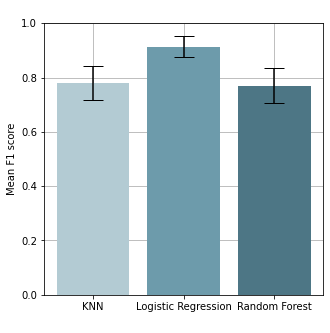

<Figure size 432x288 with 0 Axes>

In [18]:
# sns.barplot(summary, x = summary.classifier, y = summary.mean_F1, errorbar = summary.std_F1)

plt.figure(figsize = (5,5))
plt.bar(data = summary, x = "classifier", height = "mean_F1", yerr = "std_F1", color = ["#B3CBD3", "#6D9BAB", "#4D7685"],
        capsize=10, zorder = 3)
plt.grid(visible = True, zorder = 0)
plt.title(" ")
plt.xlabel(" ")
plt.ylabel("Mean F1 score") # put definition of macro F1 score, sensitivity and specificity -> doesnt favour one level over the other
plt.savefig("Classifier_selcetion.png", dpi = 300)
plt.show()
plt.clf()

In [45]:
summary

,classifier,mean_F1,std_F1
0,KNN,0.651720,0.054323
1,LogReg,0.811570,0.034383
2,RanFor,0.678059,0.065566


,F1,F2,F3,F4,F5,mean,sd
n_neighbors,,,,,,,
4,0.7358,0.6225,0.8399,0.7462,0.7568,0.657655,0.190590
5,0.7100,0.7298,0.8504,0.7688,0.7818,0.682579,0.190197
6,0.6980,0.6856,0.8455,0.7358,0.7568,0.661332,0.187228
